# fastai + waveforms

Now that we understand most of the parameters we can control when generating spectrograms, let's take a look at how fastai interacts with these generated waveforms. We'll start by importing all the stuff we need to generate waveforms.

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from fastai.vision import Path, ImageList, get_transforms, Image, open_image
import pandas as pd
import matplotlib.pyplot as plt 
import librosa
import librosa.display
from EasyDict import EasyDict
import IPython
import IPython.display
from tqdm import tqdm_notebook
from PIL import Image as pilImage
import os
import sklearn.metrics
from sklearn.preprocessing import MultiLabelBinarizer

In [11]:
DATA = Path('data')
WORK = Path('work')
TRN_CURATED = DATA/'train_curated'

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'

train = pd.read_csv(DATA/'train_curated.csv')
train_noisy_df = pd.read_csv(CSV_TRN_NOISY)

In [8]:
def read_audio(conf, pathname, trim_long_data):
    y, _ = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
        
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    elif len(y) * 2 > conf.samples:
        # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    else:
        y = np.pad(y, (1000,1000), 'constant')
        numRepeat = conf.samples // len(y)
        y = np.tile(y, numRepeat)
        #Pad the rest out
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='mfcc'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

    
def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

Let's take a minute to think about how fastai interprets waveforms. For starters, all of our images are interpreted as `128x128` squares. Previously we saw that a 5 second audio sample is represtented as a `128x321` image. This means that we're basically only ever interpreting 2 seconds of audio!

Are there any classes for which this might be a problem?

If a sound is shorter than 2 seconds but contained within a  15 second clip,  then we have only a 2/15 (13%) chance of getting a crop that actually contains the sound. 

The following example contains "Bark", "Cricket" and "Buzz" but the barking is so brief that it seems unlikely we'd get a crop that contains it.

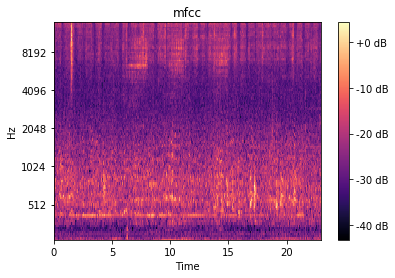

Bark, Cricket, Buzz
(128, 1470)


In [9]:
conf = EasyDict()

conf.sampling_rate = 32000
conf.duration = 5
conf.hop_length = 500 # So that there are 64 frames per second
conf.fmin = 50
conf.fmax = 14000
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

bark_cricket_buzz_path = TRN_CURATED/'3c13f5cd.wav'
bark_cricket_buzz = read_as_melspectrogram(conf, bark_cricket_buzz_path, trim_long_data=False, debug_display=True)
print("Bark, Cricket, Buzz")
print(bark_cricket_buzz.shape)

In [12]:
#Create a very small dataframe with only this sound
train_temp = train[train['fname'] == '3c13f5cd.wav']
train_temp = train_temp.append(train[train['fname'] == '3c13f5cd.wav'])
train_temp = train_temp.append(train[train['fname'] == '3c13f5cd.wav'])
train_temp = train_temp.append(train[train['fname'] == '3c13f5cd.wav'])
train_temp = train_temp.append(train[train['fname'] == '3c13f5cd.wav'])

In [13]:
train_temp

,fname,labels
1148,3c13f5cd.wav,"Bark,Cricket,Buzz"
1148,3c13f5cd.wav,"Bark,Cricket,Buzz"
1148,3c13f5cd.wav,"Bark,Cricket,Buzz"
1148,3c13f5cd.wav,"Bark,Cricket,Buzz"
1148,3c13f5cd.wav,"Bark,Cricket,Buzz"


In [14]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
#Our clasifier stuff    
src = (ImageList.from_df(train_temp, path=WORK/'image/trn_merged', suffix='.jpg')
    .split_none()
    .label_from_df(label_delim=',')
      )

data = (src.transform(tfms, size=128).databunch(bs=5))

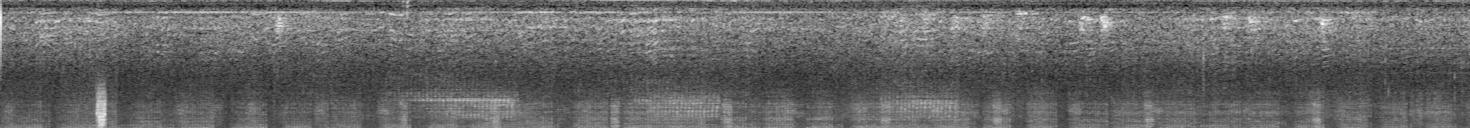

In [15]:
#Let's take a look at the image on disk
x = open_image(WORK/'image/trn_merged/3c13f5cd.wav.jpg')
x

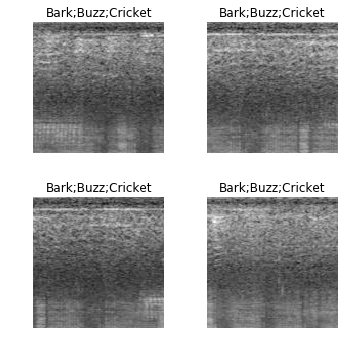

In [22]:
#Let's take a look at how our network sees this image
data.show_batch(rows=2, figsize=(5,5))

So clearly we've got a problem. We're only ever looking at a small portion of our image. How can we fix this?

Ideas:
 - Double crop size to 256x256 to capture 4 seconds of audio at a time.
   - 30% of curated data is 2 seconds or less
   - 46% of curated data is 4 seconds or less
   - 16% of test data is 2 seconds or less
   - 30% of test data is 4 seconds or less
 - Try stacking multiple 1-channel crops into a 3-channel input?
  - Idea is to capture 2 seconds * 3 = 6 seconds of input or 4 seconds * 3 = 12 seconds of input
 - Try label smoothing on longer samples? It's less likely each sample actually contains the sound we're looking for. Maybe this can help account for that?